# 1. Definição do Sistema e Análise de Malha Aberta
Utilizaremos um sistema genérico de segunda ordem. A função de transferência padrão para sistemas de segunda ordem é dada por:

$$G(s) = \frac{\omega_n^2}{s^2 + 2\zeta\omega_n s + \omega_n^2}$$

Onde:
* $\omega_n$: Frequência natural não amortecida.
* $\zeta$: Fator de amortecimento.

### Parâmetros Escolhidos
Para garantir que o sistema seja **instável** e apresente características oscilatórias crescentes, escolhemos um fator de amortecimento negativo:

* $\omega_n = 2$ rad/s
* $\zeta = -0.1$

Substituindo esses valores na equação padrão:

$$G(s) = \frac{2^2}{s^2 + 2(-0.1)(2) s + 2^2}$$

Chegamos à nossa Função de Transferência de trabalho:

$$G(s) = \frac{4}{s^2 - 0.4s + 4}$$

### Análise de Estabilidade (Cálculo dos Polos)
Podemos achar os polos do sistema:$s^2 - 0.4s + 4 = 0$:

$$s = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a} = \frac{0.4 \pm \sqrt{(-0.4)^2 - 4(1)(4)}}{2}$$
$$s = \frac{0.4 \pm \sqrt{0.16 - 16}}{2}$$
$$s = 0.2 \pm j1.99$$

Como os polos possuem **parte real positiva** ($+0.2$), eles se localizam no Semiplano Direito  do plano S. Portanto, o sistema é **INSTÁVEL**. 


Polos calculados computacionalmente: [0.2+1.98997487j 0.2-1.98997487j]


<>:24: SyntaxWarning: invalid escape sequence '\z'
<>:24: SyntaxWarning: invalid escape sequence '\z'
/tmp/ipykernel_25893/2831012441.py:24: SyntaxWarning: invalid escape sequence '\z'
  plt.title(f'Resposta ao Degrau: Sistema de 2ª Ordem com $\zeta = {zeta}$')


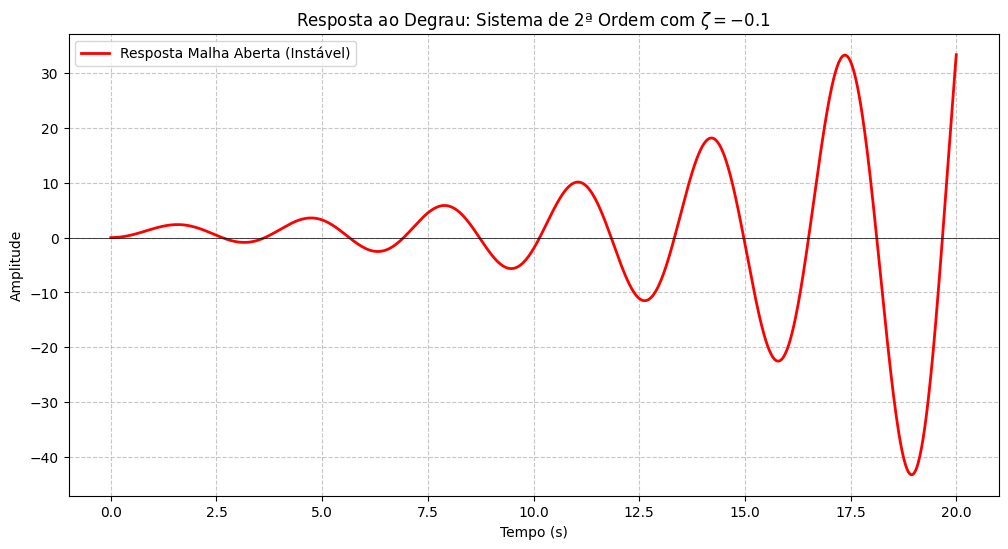

In [4]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt


wn = 2          # Frequência natural
zeta = -0.1     # Amortecimento 

# G(s) = wn^2 / (s^2 + 2*zeta*wn*s + wn^2)
num = [wn**2]
den = [1, 2*zeta*wn, wn**2]

G_s = ct.TransferFunction(num, den)

polos = ct.poles(G_s)
print(f"\nPolos calculados computacionalmente: {polos}")


t = np.linspace(0, 20, 1000)
t_out, y_out = ct.step_response(G_s, T=t) #Resposta ao degrau

plt.figure(figsize=(12, 6))
plt.plot(t_out, y_out, label='Resposta Malha Aberta (Instável)', color='red', linewidth=2)
plt.title(f'Resposta ao Degrau: Sistema de 2ª Ordem com $\zeta = {zeta}$')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.axhline(0, color='black', linewidth=0.5) # Eixo zero
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# 2. Estabilizando com PID

Nosso objetivo é estabilizar o sistema de malha fechada e atingir critérios de desempenho. Para isso, analisaremos a resposta temporal baseada em um sistema padrão de segunda ordem amortecido ($\zeta < 1$).

### As Métricas de Desempenho
Queremos minimizar três parâmetros principais:

1.  **Tempo de Subida ($t_r$):** Indica a **velocidade** do sistema.

    $$t_r \approx \frac{1.8}{\omega_n}$$
    *Para diminuir $t_r$, precisamos aumentar a frequência natural $\omega_n$.*

2.  **Tempo de Acomodação ($t_s$):** Tempo para o erro entrar e permanecer dentro de uma faixa (ex: 2%) do valor final.
    $$t_s \approx \frac{4}{\zeta \omega_n}$$
    *Depende do produto do amortecimento pela frequência (parte real do polo).*

3.  **Sobressinal ($M_p$ - Overshoot):** O quanto o pico máximo ultrapassa o valor final (em %).
    $$M_p(\%) =  e^{\frac{-\pi \zeta}{\sqrt{1-\zeta^2}}}$$
    *Inversamente proporcional do fator de amortecimento $\zeta$. 

---

### O Papel de cada Ganho do PID ($K_p, K_i, K_d$)

### 1. Ação Proporcional ($K_p$):
O termo Proporcional diminui o erro mas nunca zera, seria preciso um kp infinito para zerar o erro.
$\epsilon(\infty) = \frac{1}{1 + k_p}$

### 2. Ação Derivativa ($K_d$): 
O termo Derivativo olha para a **taxa de variação do erro**. Ele percebe se o sistema está indo rápido demais em direção ao erro e aplica uma força contrária. Adiciona um zero e melhora a estabilidade.


### 3. Ação Integral ($K_i$):
O termo Integral olha para o histórico do erro. Ele soma o erro ao longo do tempo. Ele é o unico capaz de zerar o erro, mas piora a estabilidade.

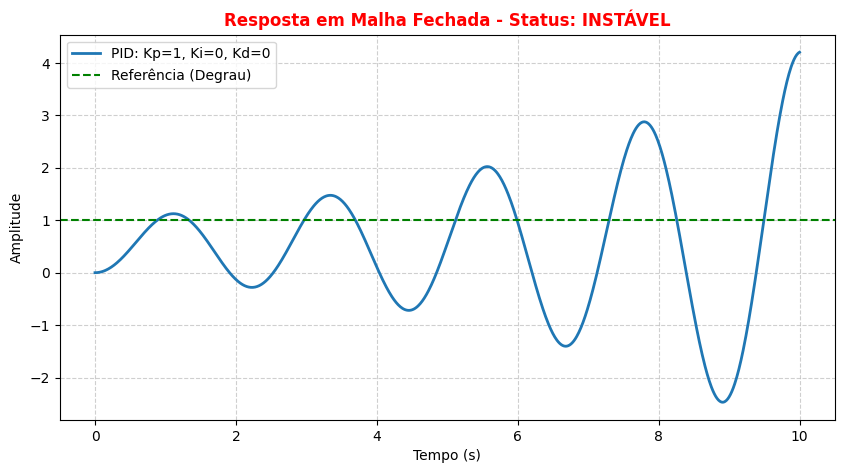

--- Métricas Alcançadas (INSTÁVEL) ---
Tempo de Subida (tr):     nan s
Tempo de Acomodação (ts): nan s
Sobressinal (Mp):         nan %
Pico (Peak):              inf
------------------------------


In [ ]:
def testar_pid(Kp, Ki, Kd, sistema_G):

    # C(s) = Kds² + kps¹ + kis⁰ / (1s¹ + 0s0); 
    ctrl = ct.TransferFunction([Kd, Kp, Ki], [1, 0])
    
    # Realimentação negativa unitaria
    sistema_fechado = ct.feedback(ctrl * sistema_G, 1)
    
    polos = ct.poles(sistema_fechado)
    instavel = np.any(np.real(polos) > 0) #verifica se é instavel
    
    t = np.linspace(0, 10, 1000)
    t_out, y_out = ct.step_response(sistema_fechado, T=t)
    
    #Cálculo das Métricas 
    info = ct.step_info(sistema_fechado)
    

    plt.figure(figsize=(10, 5))
    plt.plot(t_out, y_out, label=f'PID: Kp={Kp}, Ki={Ki}, Kd={Kd}', linewidth=2)
    plt.axhline(1, color='green', linestyle='--', label='Referência (Degrau)')
    
    status = "INSTÁVEL" if instavel else "ESTÁVEL"
    cor_titulo = "red" if instavel else "blue"
    
    plt.title(f'Resposta em Malha Fechada - Status: {status}', color=cor_titulo, fontweight='bold')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()
    
    # --- Relatório Numérico ---
    print(f"--- Métricas Alcançadas ({status}) ---")
    print(f"Tempo de Subida (tr):     {info['RiseTime']:.4f} s")
    print(f"Tempo de Acomodação (ts): {info['SettlingTime']:.4f} s")
    print(f"Sobressinal (Mp):         {info['Overshoot']:.2f} %")
    print(f"Pico (Peak):              {info['Peak']:.4f}")
    print("-" * 30)



testar_pid(Kp=1, Ki=0, Kd=0, sistema_G=G_s)

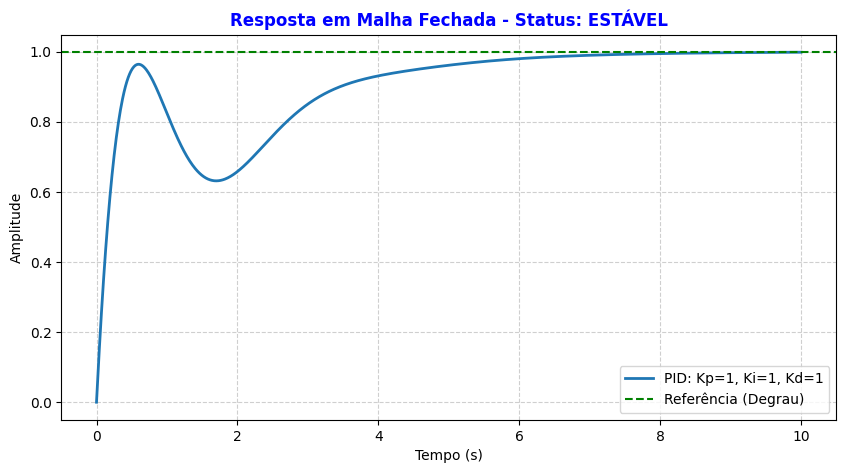

--- Métricas Alcançadas (ESTÁVEL) ---
Tempo de Subida (tr):     0.3737 s
Tempo de Acomodação (ts): 6.0728 s
Sobressinal (Mp):         0.00 %
Pico (Peak):              0.9990
------------------------------


In [27]:
testar_pid(Kp=1, Ki=1, Kd=1, sistema_G=G_s)

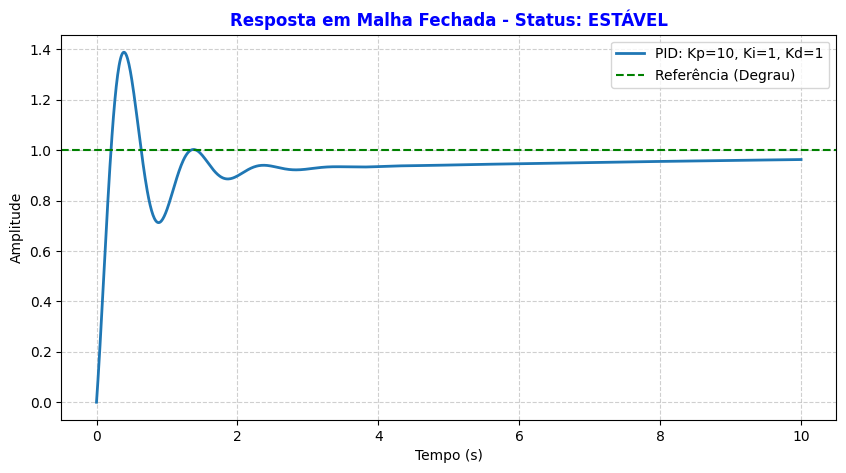

--- Métricas Alcançadas (ESTÁVEL) ---
Tempo de Subida (tr):     0.1521 s
Tempo de Acomodação (ts): 16.8426 s
Sobressinal (Mp):         38.75 %
Pico (Peak):              1.3875
------------------------------


In [28]:
testar_pid(Kp=10, Ki=1, Kd=1, sistema_G=G_s)

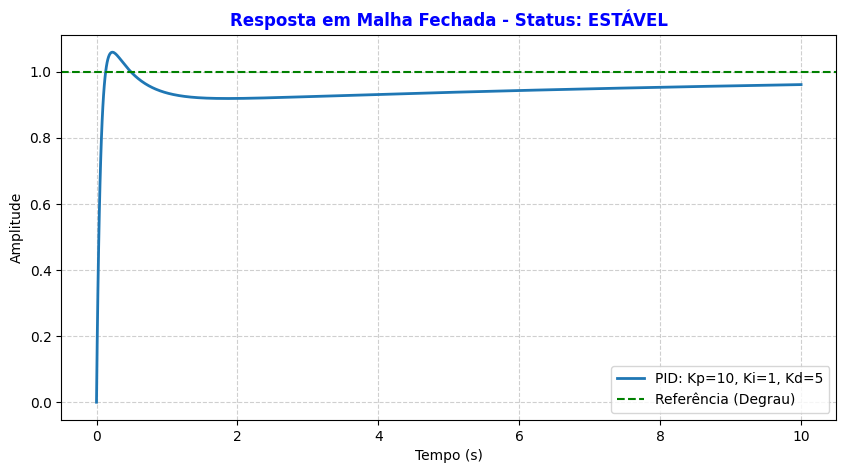

--- Métricas Alcançadas (ESTÁVEL) ---
Tempo de Subida (tr):     0.0890 s
Tempo de Acomodação (ts): nan s
Sobressinal (Mp):         5.91 %
Pico (Peak):              1.0591
------------------------------


In [29]:
testar_pid(Kp=10, Ki=1, Kd=5, sistema_G=G_s)

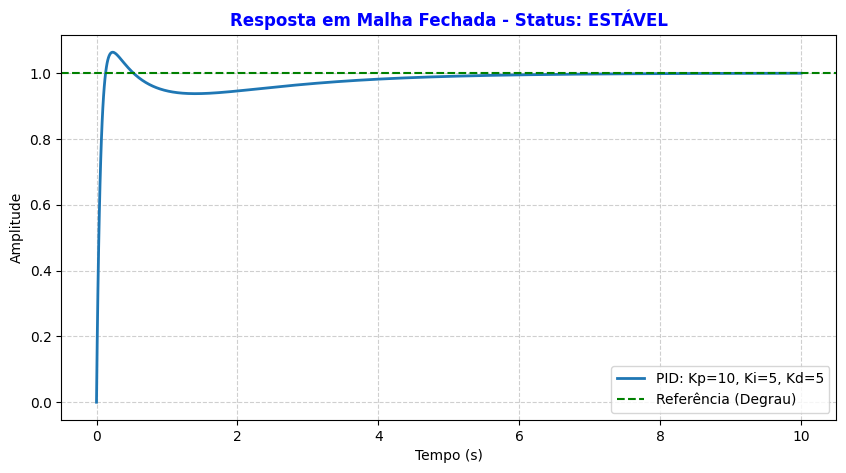

--- Métricas Alcançadas (ESTÁVEL) ---
Tempo de Subida (tr):     0.0889 s
Tempo de Acomodação (ts): 3.8628 s
Sobressinal (Mp):         6.34 %
Pico (Peak):              1.0634
------------------------------


In [30]:
testar_pid(Kp=10, Ki=5, Kd=5, sistema_G=G_s)

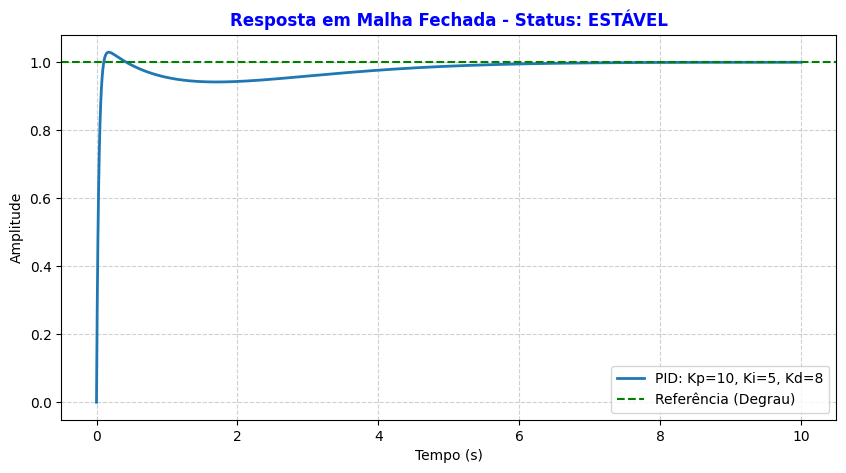

--- Métricas Alcançadas (ESTÁVEL) ---
Tempo de Subida (tr):     0.0595 s
Tempo de Acomodação (ts): 4.2218 s
Sobressinal (Mp):         2.98 %
Pico (Peak):              1.0298
------------------------------


In [31]:
testar_pid(Kp=10, Ki=5, Kd=8, sistema_G=G_s)

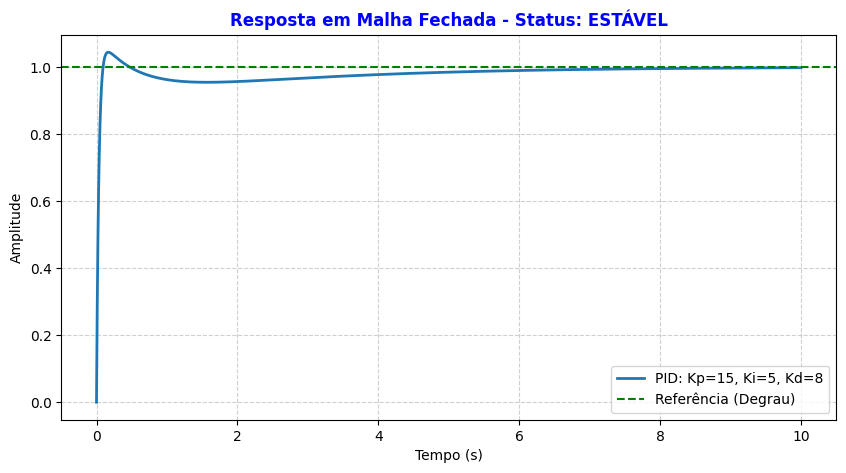

--- Métricas Alcançadas (ESTÁVEL) ---
Tempo de Subida (tr):     0.0609 s
Tempo de Acomodação (ts): nan s
Sobressinal (Mp):         4.38 %
Pico (Peak):              1.0438
------------------------------


In [32]:
testar_pid(Kp=15, Ki=5, Kd=8, sistema_G=G_s)

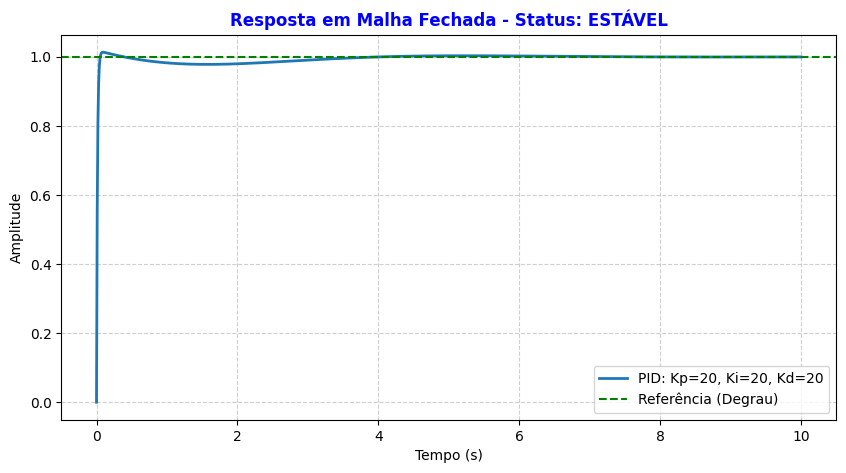

--- Métricas Alcançadas (ESTÁVEL) ---
Tempo de Subida (tr):     0.0262 s
Tempo de Acomodação (ts): 2.0194 s
Sobressinal (Mp):         1.34 %
Pico (Peak):              1.0134
------------------------------


In [43]:
testar_pid(Kp=20, Ki=20, Kd=20, sistema_G=G_s)

# 3. Discretização e Análise de Taxa de Amostragem

Nesta etapa, vamos converter nosso sistema de malha fechada contínuo $T(s)$ para um equivalente discreto $T(z)$. 

### O Critério de Nyquist
Para evitar aliasing, a frequência de amostragem $\omega_s$ deve respeitar o Teorema da Amostragem:

$$\omega_s > 2 \cdot \omega_{m}$$

Onde $2\omega_{m}$ representa a taxa de nyquist.
Sabemos que $$\omega_s = \frac{2 \pi}{T_s}$$
$$\frac{2 \pi}{T_s} > 2\cdot \omega_m$$
$$T_s <\frac{\pi}{\omega_m}$$


Vamos testar 3 cenários de Tempo de Amostragem ($T_s$):
1.  **Sem Aliasing (Ideal):** $T_s$ muito pequeno (amostragem rápida).
2.  **No Limite de Nyquist:** $T_s$ calculado exatamente no limite da largura de banda. 
3.  **Com Aliasing (Subamostragem):** $T_s$ muito grande (amostragem lenta). 

In [ ]:
# 1. Recriando o Sistema em Malha Fechada com os ganhos escolhidos
Kp, Ki, Kd = 20, 20, 20
ctrl = ct.TransferFunction([Kd, Kp, Ki], [1, 0])
sys_cl = ct.feedback(ctrl * G_s, 1)

wm = ct.bandwidth(sys_cl)
print(f"Largura de Banda do Sistema (wm): {wm:.2f} rad/s")

Ts_limite = np.pi / wm

# Cenário 1: Sem Aliasing (Usando criterio de 1%)
Ts_bom = Ts_limite / 100

# Cenário 2: No Limite 
Ts_medio = Ts_limite 

# Cenário 3: Com Aliasing 
Ts_ruim = Ts_limite * 10

print(f"\nTempos de Amostragem Escolhidos:")
print(f"1. Sem Aliasing (Rápido): {Ts_bom:.4f} s")
print(f"2. No Limite (Crítico):   {Ts_medio:.4f} s")
print(f"3. Com Aliasing (Lento):  {Ts_ruim:.4f} s")

Largura de Banda do Sistema (wm): 81.24 rad/s

Tempos de Amostragem Escolhidos:
1. Sem Aliasing (Rápido): 0.0004 s
2. No Limite (Crítico):   0.0387 s
3. Com Aliasing (Lento):  0.3867 s


In [ ]:
cenarios = [
    (Ts_bom, 'Sem Aliasing (Ts Pequeno)', 'green', '-'),
    (Ts_medio, 'No Limite de Nyquist', 'orange', '--'),
    (Ts_ruim, 'Com Aliasing (Ts Grande)', 'red', '-.')
]

for Ts, label, cor, estilo in cenarios:
    print(f"\n-----------------------------------------------------------------------")
    print(f"CENÁRIO: {label} (Ts = {Ts:.4f} s)")
    
    #usando retentor de ordem 0
    sys_discreto = ct.sample_system(sys_cl, Ts, method='zoh')
    
    # Imprime a Função de Transferência em Z
    print(sys_discreto)
    
    # Analisando Estabilidade via Polos em Z
    polos_z = ct.poles(sys_discreto)
    print(polos_z)
    max_polo = np.max(np.abs(polos_z))
    
    print(f"Maior polo (módulo): {max_polo:.4f}")
    if max_polo > 1:
        print(">> STATUS: INSTÁVEL (Polo fora do círculo unitário)")
    else:
        print(">> STATUS: ESTÁVEL")
    
    print(f"\n-----------------------------------------------------------------------")


-----------------------------------------------------------------------
CENÁRIO: Sem Aliasing (Ts Pequeno) (Ts = 0.0004 s)
<TransferFunction>: sys[437]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.0003866902925179158

  0.03047 z^2 - 0.06093 z + 0.03046
  ---------------------------------
  z^3 - 2.97 z^2 + 2.939 z - 0.9697
[0.9997957 +0.00033246j 0.9997957 -0.00033246j 0.97008459+0.j        ]
Maior polo (módulo): 0.9998
>> STATUS: ESTÁVEL

-----------------------------------------------------------------------

-----------------------------------------------------------------------
CENÁRIO: No Limite de Nyquist (Ts = 0.0387 s)
<TransferFunction>: sys[437]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.03866902925179158

     0.9682 z^2 - 1.898 z + 0.9314
  -----------------------------------
  z^3 - 2.006 z^2 + 1.054 z - 0.04605
[0.97923859+0.03257461j 0.97923859-0.03257461j 0.04796898+0.j        ]
Maior polo (módulo): 0.9798
>> STATUS: ESTÁVEL

--------------

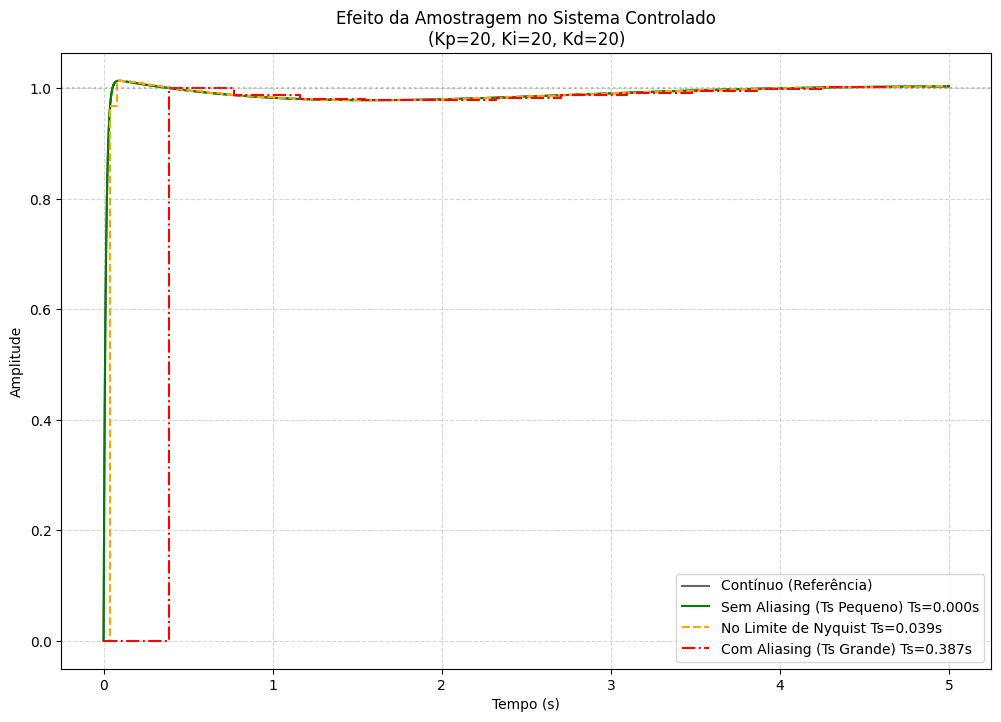

In [67]:
plt.figure(figsize=(12, 8))

# Plotar o Contínuo (Referência Perfeita)
t = np.linspace(0, 5, 1000)
t_cont, y_cont = ct.step_response(sys_cl, T=t)
plt.plot(t_cont, y_cont, label='Contínuo (Referência)', color='black', linewidth=1.5, alpha=0.6)


for Ts, label, cor, estilo in cenarios:
    # Usando retentor de ordem 0
    sys_discreto = ct.sample_system(sys_cl, Ts, method='zoh')
    
    t_disc = np.arange(0, 5, Ts)
    t_out, y_out = ct.step_response(sys_discreto, T=t_disc)
    
    plt.step(t_out, y_out, label=f'{label} Ts={Ts:.3f}s', color=cor, linestyle=estilo, where='post')

plt.title(f'Efeito da Amostragem no Sistema Controlado\n(Kp={Kp}, Ki={Ki}, Kd={Kd})')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.axhline(1, color='gray', linestyle=':', alpha=0.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()